In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1> LSTM1 -GRU1 </h1>

In [12]:
from tensorflow.keras.layers import LSTM, Conv1D, GRU
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 178374 (696.77 KB)
Trainable params: 178

In [13]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 14s 73ms/step - loss: 1.2217 - accuracy: 0.4831 - val_loss: 0.8938 - val_accuracy: 0.6074
Epoch 2/10
58/58 [==============================] - 2s 41ms/step - loss: 0.7005 - accuracy: 0.6961 - val_loss: 0.5288 - val_accuracy: 0.7752
Epoch 3/10
58/58 [==============================] - 2s 35ms/step - loss: 0.5160 - accuracy: 0.7859 - val_loss: 0.3605 - val_accuracy: 0.8613
Epoch 4/10
58/58 [==============================] - 2s 39ms/step - loss: 0.3272 - accuracy: 0.8757 - val_loss: 0.2313 - val_accuracy: 0.9170
Epoch 5/10
58/58 [==============================] - 2s 42ms/step - loss: 0.2351 - accuracy: 0.9128 - val_loss: 0.1974 - val_accuracy: 0.9229
Epoch 6/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1725 - accuracy: 0.9362 - val_loss: 0.1469 - val_accuracy: 0.9356
Epoch 7/10
58/58 [==============================] - 2s 28ms/step - loss: 0.1499 - accuracy: 0.9395 - val_loss: 0.1329 - val_accuracy: 0.9397
Epoch 8/10
5

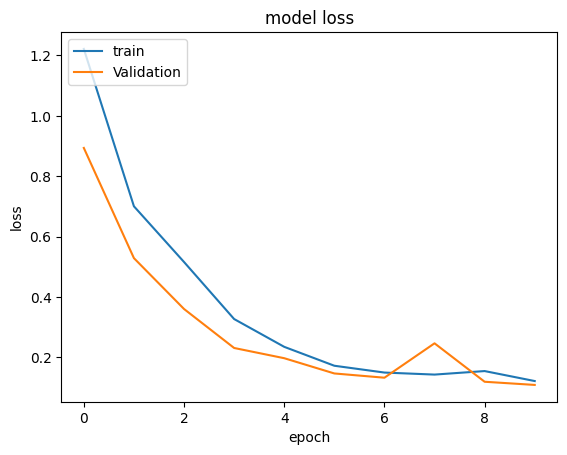

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

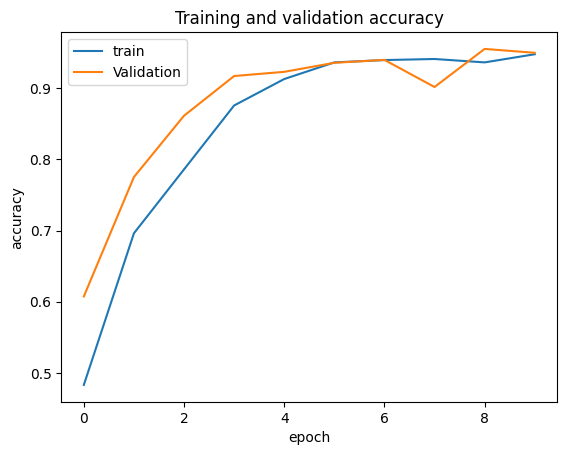

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 10ms/step
[[444   4  48   0   0   0]
 [ 18 437  16   0   0   0]
 [  1   1 418   0   0   0]
 [  1  20   0 371  93   6]
 [  2   1   0  79 450   0]
 [  0  27   0   0   0 510]]
0.8924329826942654
0.891824056852812
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       496
           1       0.89      0.93      0.91       471
           2       0.87      1.00      0.93       420
           3       0.82      0.76      0.79       491
           4       0.83      0.85      0.84       532
           5       0.99      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

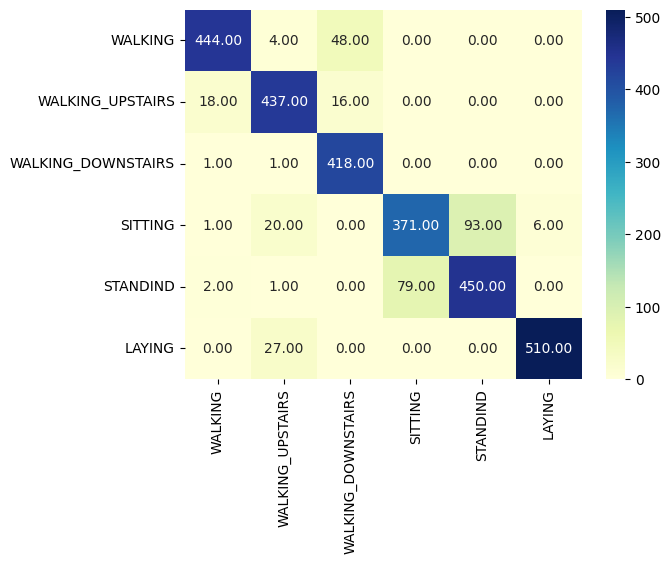

In [16]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> GRU1- LSTM1 </h1>


In [17]:
from tensorflow.keras.layers import LSTM, Conv1D, GRU
model = Sequential()
model.add(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 193606 (756.27 KB)
Trainable params: 193

In [18]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 10s 63ms/step - loss: 1.2291 - accuracy: 0.4626 - val_loss: 0.9770 - val_accuracy: 0.5825
Epoch 2/10
58/58 [==============================] - 1s 24ms/step - loss: 0.8511 - accuracy: 0.6420 - val_loss: 0.6616 - val_accuracy: 0.7076
Epoch 3/10
58/58 [==============================] - 2s 27ms/step - loss: 0.6407 - accuracy: 0.7265 - val_loss: 0.4721 - val_accuracy: 0.8033
Epoch 4/10
58/58 [==============================] - 2s 28ms/step - loss: 0.4043 - accuracy: 0.8609 - val_loss: 0.3881 - val_accuracy: 0.8722
Epoch 5/10
58/58 [==============================] - 1s 23ms/step - loss: 0.3074 - accuracy: 0.8980 - val_loss: 0.2351 - val_accuracy: 0.9130
Epoch 6/10
58/58 [==============================] - 1s 21ms/step - loss: 0.2166 - accuracy: 0.9244 - val_loss: 0.1878 - val_accuracy: 0.9257
Epoch 7/10
58/58 [==============================] - 1s 20ms/step - loss: 0.1743 - accuracy: 0.9400 - val_loss: 0.1462 - val_accuracy: 0.9456
Epoch 8/10
5

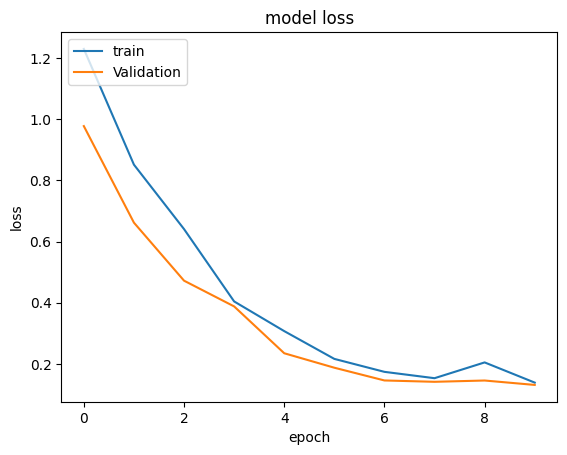

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

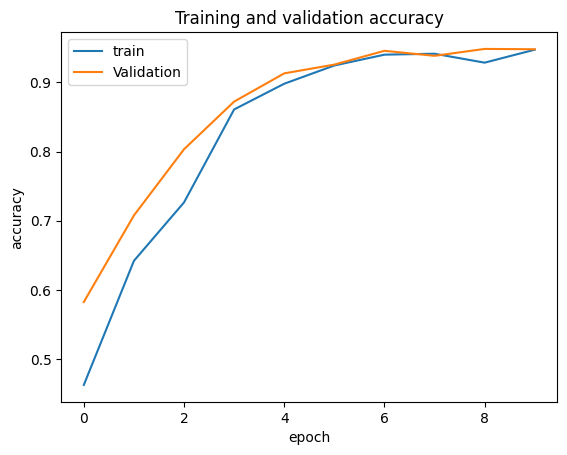

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 7ms/step
[[459  11  26   0   0   0]
 [ 32 423  15   0   1   0]
 [  2   1 417   0   0   0]
 [  0   3   0 417  70   1]
 [  2   3   0 125 402   0]
 [  0   0   0   0   0 537]]
0.9009161859518154
0.9005234687547174
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       496
           1       0.96      0.90      0.93       471
           2       0.91      0.99      0.95       420
           3       0.77      0.85      0.81       491
           4       0.85      0.76      0.80       532
           5       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

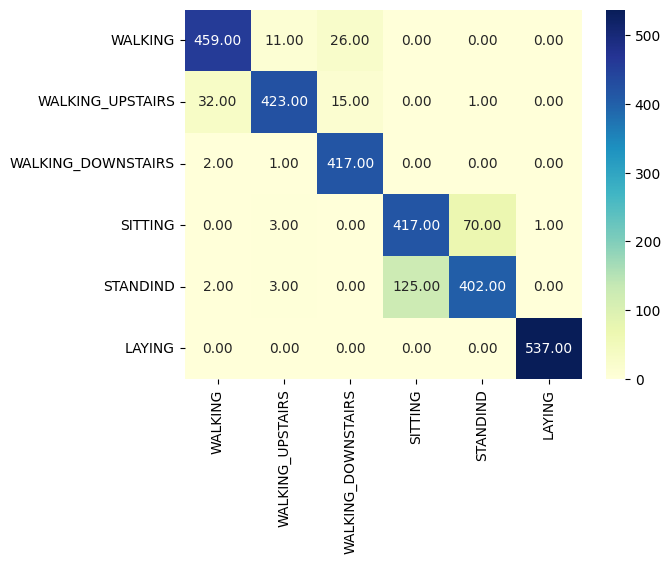

In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> GRU2 - LSTM 1 </h1>


In [27]:
from tensorflow.keras.layers import LSTM, Conv1D, GRU
model = Sequential()
model.add(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences = True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_9 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_6 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_10 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [28]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 9s 48ms/step - loss: 1.1971 - accuracy: 0.4872 - val_loss: 1.0921 - val_accuracy: 0.5426
Epoch 2/10
58/58 [==============================] - 2s 29ms/step - loss: 0.9525 - accuracy: 0.5936 - val_loss: 0.7476 - val_accuracy: 0.6668
Epoch 3/10
58/58 [==============================] - 2s 29ms/step - loss: 0.6496 - accuracy: 0.7009 - val_loss: 0.5776 - val_accuracy: 0.7384
Epoch 4/10
58/58 [==============================] - 2s 32ms/step - loss: 0.5030 - accuracy: 0.7998 - val_loss: 0.2894 - val_accuracy: 0.8985
Epoch 5/10
58/58 [==============================] - 2s 30ms/step - loss: 0.2938 - accuracy: 0.8993 - val_loss: 0.1870 - val_accuracy: 0.9252
Epoch 6/10
58/58 [==============================] - 2s 33ms/step - loss: 0.2240 - accuracy: 0.9223 - val_loss: 0.1580 - val_accuracy: 0.9433
Epoch 7/10
58/58 [==============================] - 2s 34ms/step - loss: 0.1592 - accuracy: 0.9389 - val_loss: 0.2001 - val_accuracy: 0.9207
Epoch 8/10
58

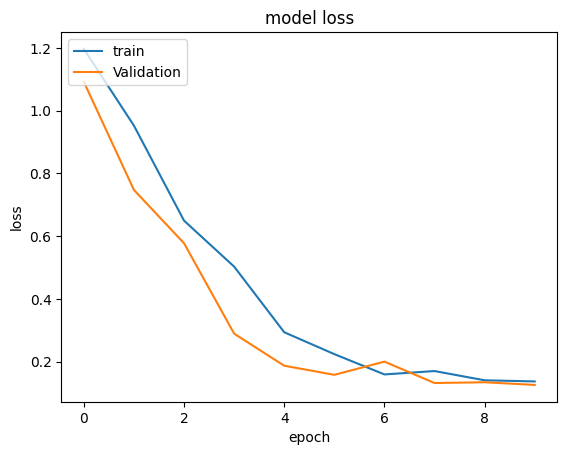

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

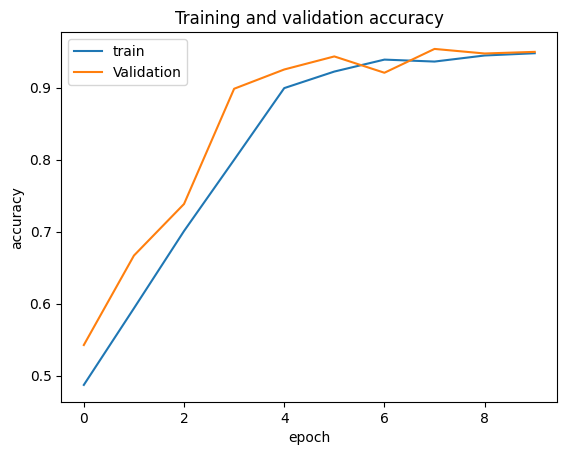

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 10ms/step
[[463  33   0   0   0   0]
 [ 38 432   1   0   0   0]
 [  2  72 346   0   0   0]
 [ 16   9   0 418  48   0]
 [ 10   0   0 123 399   0]
 [  0  27   0   0   0 510]]
0.8713946386155412
0.8725348077409352
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       496
           1       0.75      0.92      0.83       471
           2       1.00      0.82      0.90       420
           3       0.77      0.85      0.81       491
           4       0.89      0.75      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.88      0.87      0.87      2947
weighted avg       0.88      0.87      0.87      2947



<Axes: >

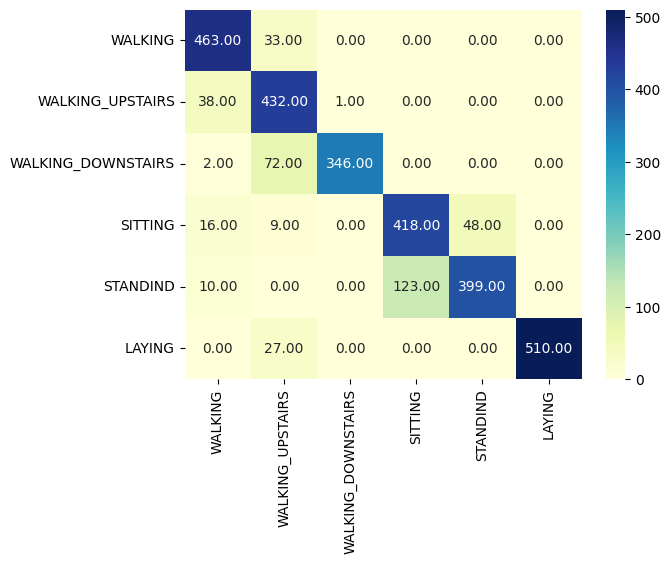

In [31]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> GRU1 - LSTM 2 </h1>


In [42]:
from tensorflow.keras.layers import LSTM, Conv1D, GRU
model = Sequential()
model.add(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 128, 128)          53376     
                                                                 
 dropout_19 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_20 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)               

In [43]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 13s 80ms/step - loss: 1.2180 - accuracy: 0.4801 - val_loss: 0.8741 - val_accuracy: 0.6519
Epoch 2/10
58/58 [==============================] - 2s 31ms/step - loss: 0.7983 - accuracy: 0.6500 - val_loss: 0.6510 - val_accuracy: 0.7257
Epoch 3/10
58/58 [==============================] - 2s 32ms/step - loss: 0.5947 - accuracy: 0.7405 - val_loss: 0.4962 - val_accuracy: 0.7770
Epoch 4/10
58/58 [==============================] - 2s 34ms/step - loss: 0.4790 - accuracy: 0.7941 - val_loss: 0.3853 - val_accuracy: 0.8527
Epoch 5/10
58/58 [==============================] - 2s 31ms/step - loss: 0.3483 - accuracy: 0.8791 - val_loss: 0.2129 - val_accuracy: 0.9161
Epoch 6/10
58/58 [==============================] - 2s 31ms/step - loss: 0.2263 - accuracy: 0.9157 - val_loss: 0.1596 - val_accuracy: 0.9415
Epoch 7/10
58/58 [==============================] - 2s 33ms/step - loss: 0.1839 - accuracy: 0.9339 - val_loss: 0.1554 - val_accuracy: 0.9442
Epoch 8/10
5

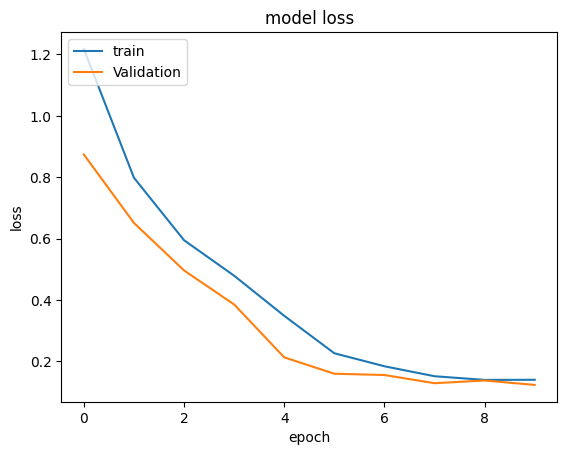

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

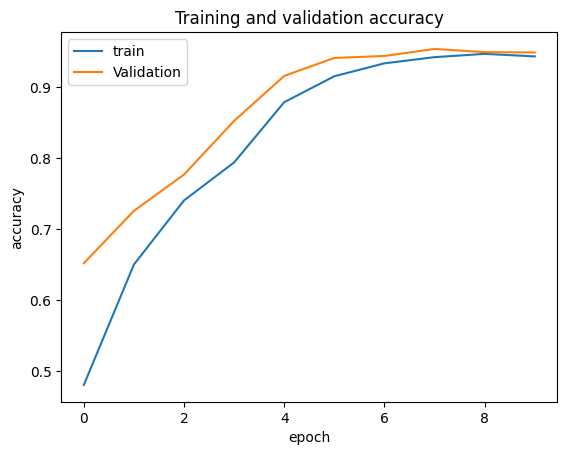

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 8ms/step
[[467   5  24   0   0   0]
 [ 24 428  17   0   2   0]
 [  7   1 412   0   0   0]
 [  0   1   0 418  66   6]
 [  0   0   0 126 406   0]
 [  0  21   0   0   0 516]]
0.8982015609093994
0.8981077539797592
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       496
           1       0.94      0.91      0.92       471
           2       0.91      0.98      0.94       420
           3       0.77      0.85      0.81       491
           4       0.86      0.76      0.81       532
           5       0.99      0.96      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

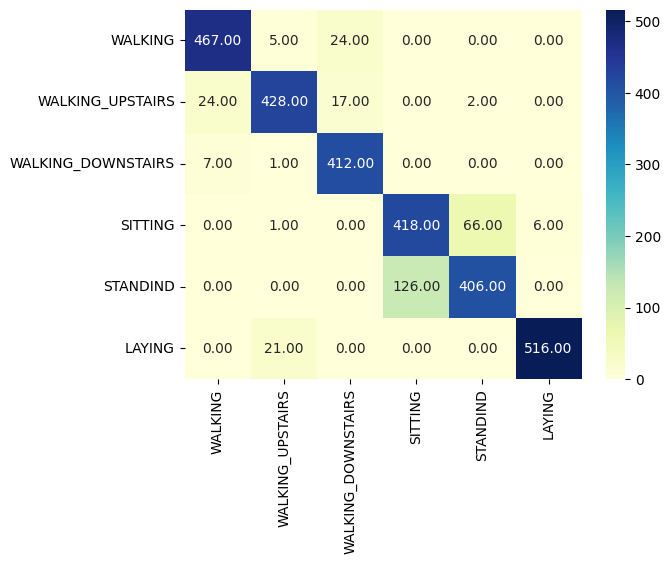

In [46]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> GRU2-LSTM2 </h1>

In [37]:
from tensorflow.keras.layers import LSTM, Conv1D, GRU
model = Sequential()
model.add(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences = True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_15 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_9 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_16 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_17 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 128)              

In [38]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 16s 82ms/step - loss: 1.1753 - accuracy: 0.4993 - val_loss: 1.0217 - val_accuracy: 0.5558
Epoch 2/10
58/58 [==============================] - 2s 40ms/step - loss: 0.8896 - accuracy: 0.6228 - val_loss: 0.7370 - val_accuracy: 0.6673
Epoch 3/10
58/58 [==============================] - 2s 40ms/step - loss: 0.5807 - accuracy: 0.7406 - val_loss: 0.4437 - val_accuracy: 0.8359
Epoch 4/10
58/58 [==============================] - 2s 41ms/step - loss: 0.4230 - accuracy: 0.8324 - val_loss: 0.4199 - val_accuracy: 0.8259
Epoch 5/10
58/58 [==============================] - 2s 40ms/step - loss: 0.4230 - accuracy: 0.8467 - val_loss: 0.5051 - val_accuracy: 0.7947
Epoch 6/10
58/58 [==============================] - 2s 42ms/step - loss: 0.3088 - accuracy: 0.8867 - val_loss: 0.2036 - val_accuracy: 0.9270
Epoch 7/10
58/58 [==============================] - 2s 43ms/step - loss: 0.1869 - accuracy: 0.9339 - val_loss: 0.1481 - val_accuracy: 0.9447
Epoch 8/10
5

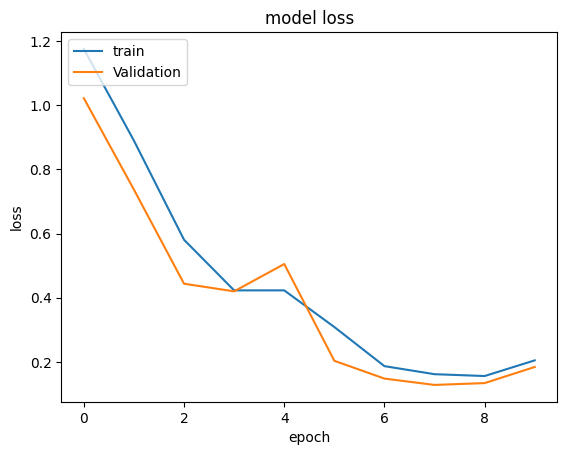

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

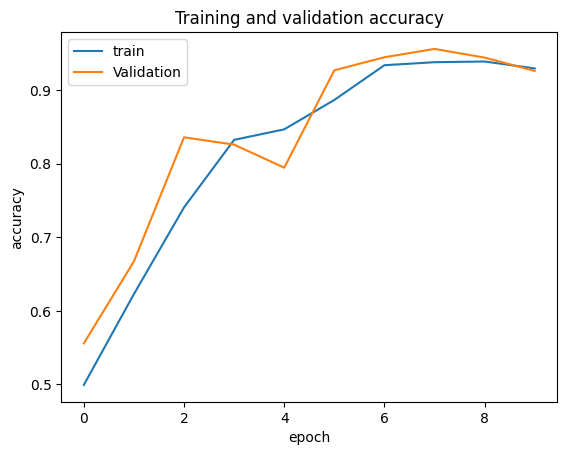

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 13ms/step
[[448   5  25   0  18   0]
 [ 70 385  13   0   3   0]
 [  1   7 412   0   0   0]
 [  1   4   0 355 128   3]
 [  0   0   0  44 488   0]
 [  0   1   0   0   0 536]]
0.8903970139124533
0.8895514051251401
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       496
           1       0.96      0.82      0.88       471
           2       0.92      0.98      0.95       420
           3       0.89      0.72      0.80       491
           4       0.77      0.92      0.83       532
           5       0.99      1.00      1.00       537

    accuracy                           0.89      2947
   macro avg       0.90      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

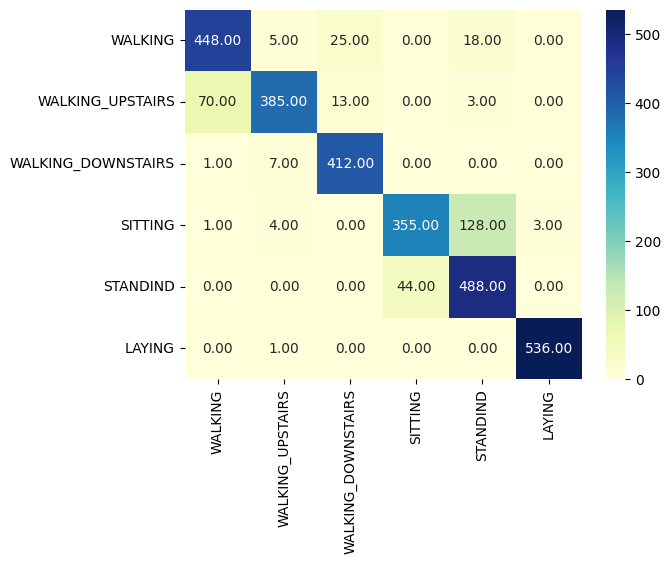

In [41]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')